In [3]:
import numpy as np
import projectLib as lib
import matplotlib.pyplot as plt
import inspect

# set highest rating
K = 5
F = 3
eps=0.1

def softmax(x):
    # Numerically stable softmax function
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def ratingsPerMovie(training):
    movies = [x[0] for x in training]
    u_movies = np.unique(movies).tolist()
    return np.array([[i, movie, len([x for x in training if x[0] == movie])] for i, movie in enumerate(u_movies)])

def getV(ratingsForUser):
    # ratingsForUser is obtained from the ratings for user library
    # you should return a binary matrix ret of size m x K, where m is the number of movies
    #   that the user has seen. ret[i][k] = 1 if the user
    #   has rated movie ratingsForUser[i, 0] with k stars
    #   otherwise it is 0
    ret = np.zeros((len(ratingsForUser), K))
    for i in range(len(ratingsForUser)):
        ret[i, ratingsForUser[i, 1]-1] = 1.0
    return ret

def getInitialWeights(m, F, K):
    # m is the number of visible units
    # F is the number of hidden units
    # K is the highest rating (fixed to 5 here)
    return np.random.normal(0, 0.1, (m, F, K))

In [4]:
training = lib.getTrainingData()
ratingsForUser1 = lib.getRatingsForUser(1, training)

In [5]:
# ratingsPerMovie(training)
v = getV(ratingsForUser1)
# v.shape
w = getInitialWeights(v.shape[0],F,5)

In [6]:
trStats = lib.getUsefulStats(training)
W = getInitialWeights(trStats["n_movies"], F, K)

In [7]:
def sig(x):
    ### TO IMPLEMENT ###
    # x is a real vector of size n
    # ret should be a vector of size n where ret_i = sigmoid(x_i)
    return 1/(1+np.exp(-x))

def visibleToHiddenVec(v, w, hid_bias):
    ### TO IMPLEMENT ###
    # v is a matrix of size m x 5. Each row is a binary vector representing a rating
    #    OR a probability distribution over the rating
    # w is a list of matrices of size m x F x 5
    # ret should be a vector of size F
    m,f,K=w.shape
    output=list()
    for i in range(f):
        summ=0
        for k in range(K):
            for j in range(m):
                summ+=v[j,k]*w[j,i,k]
        output.append(summ)

    return sig(np.array(output)+hid_bias)
    

def hiddenToVisible(h, w, vis_bias):
    ### TO IMPLEMENT ###
    # h is a binary vector of size F
    # w is an array of size m x F x 5
    # ret should be a matrix of size m x 5, where m
    #   is the number of movies the user has seen.
    #   Remember that we do not reconstruct movies that the user
    #   has not rated! (where reconstructing means getting a distribution
    #   over possible ratings).
    #   We only do so when we predict the rating a user would have given to a movie.
#     print(w.shape)
    output=w[:,0,:]*h[0]
    m,f,k=w.shape
    for i in range(1,f):
        output+=w[:,i,:]*h[i]
    return sig(output+vis_bias)

def probProduct(v, p):
    # v is a matrix of size m x 5
    # p is a vector of size F, activation of the hidden units
    # returns the gradient for visible input v and hidden activations p
    ret = np.zeros((v.shape[0], p.size, v.shape[1]))
    for i in range(v.shape[0]):
        for j in range(p.size):
            for k in range(v.shape[1]):
                ret[i, j, k] = v[i, k] * p[j]
    return ret

def sample(p):
    # p is a vector of real numbers between 0 and 1
    # ret is a vector of same size as p, where ret_i = Ber(p_i)
    # In other word we sample from a Bernouilli distribution with
    # parameter p_i to obtain ret_i
    samples = np.random.random(p.size)
    return np.array(samples <= p, dtype=int)

def getPredictedDistribution(v, w, wq,vis_bias,hid_bias):
    ### TO IMPLEMENT ###
    # This function returns a distribution over the ratings for movie q, if user data is v
    # v is the dataset of the user we are predicting the movie for
    #   It is a m x 5 matrix, where m is the number of movies in the
    #   dataset of this user.
    # w is the weights array for the current user, of size m x F x 5
    # wq is the weight matrix of size F x 5 for movie q
    #   If W is the whole weights array, then wq = W[q, :, :]
    # You will need to perform the same steps done in the learning/unlearning:
    #   - Propagate the user input to the hidden units
    #   - Sample the state of the hidden units
    #   - Backpropagate these hidden states to obtain
    #       the distribution over the movie whose associated weights are wq
    # ret is a vector of size 5
    m,f,K=w.shape
    p_learn = visibleToHiddenVec(v,w,hid_bias)
    PG = probProduct(v, p_learn)
    hidden_activations = sample(p_learn)
    v_negative = hiddenToVisible(hidden_activations, wq.reshape(1,wq.shape[0],wq.shape[1]),vis_bias)

    return v_negative.reshape(5)

def predictRatingMax(ratingDistribution):
    ### TO IMPLEMENT ###
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the one with the highest probability
    max_indices = np.where(ratingDistribution == np.amax(ratingDistribution))[0]
    if max_indices.shape[0] == 1:
        result = max_indices.item()
    else:
        result = 2
    return result+1

def predictRatingMean(ratingDistribution):
    ### TO IMPLEMENT ###
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over ratingDistribution
    normalized = [i/sum(ratingDistribution) for i in ratingDistribution]
    result = 0 
    for k in range(ratingDistribution.shape[0]):
        result += normalized[k]*(k+1)
    return result

def predictRatingExp(ratingDistribution):
    ### TO IMPLEMENT ###
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over
    # the softmax applied to ratingDistribution
    softmax = np.exp(ratingDistribution)/sum(np.exp(ratingDistribution))
#     print(softmax)
    result = 0 
    for k in range(len(ratingDistribution)):
        result += softmax[k]*(k+1)
#         print (result)
    return result

def predictMovieForUser(q, user, W, training,vis_bias,hid_bias, predictType="exp"):
    # movie is movie idx
    # user is user ID
    # type can be "max" or "exp"
    ratingsForUser = lib.getRatingsForUser(user, training)
    v = getV(ratingsForUser)
#     print(np.where(ratingsForUser[:,0]==q))
    ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], W[q, :, :],vis_bias[q],hid_bias)#[np.where(ratingsForUser[:,0]==q)[0][0]]
    if predictType == "max":
        return predictRatingMax(ratingDistribution)
    elif predictType == "mean":
        return predictRatingMean(ratingDistribution)
    else:
        return predictRatingExp(ratingDistribution)

def predict(movies, users, W, training,vis_bias,hid_bias, predictType="exp"):
    # given a list of movies and users, predict the rating for each (movie, user) pair
    # used to compute RMSE
    return [predictMovieForUser(movie, user, W, training,vis_bias,hid_bias, predictType=predictType) for (movie, user) in zip(movies, users)]

In [35]:
def adaptiveLearn(learning_rate_type=['constant','adapt','time', 'step', 'exponential'], 
                  lr=0.0001, k=0.1, epoch=None, drop=0.5, epochs_drop=10.0):
#time-based decay, step decay and exponential decay
    if learning_rate_type == 'constant':
        return lr
    elif learning_rate_type == 'adapt':
        return lr/(epoch**2)
    elif learning_rate_type == 'time':
        return lr/(1.0+k*epoch)
    elif learning_rate_type == 'step':
        return lr*np.power(drop,np.floor((1+epoch)/epochs_drop))
    elif learning_rate_type == 'exponential':
        return lr*np.exp(-k*epoch)
        

In [9]:
# q = np.random.choice(ratingsForUser1[:, 0])
# index = np.where(ratingsForUser1[:, 0]==q)[0].item()
# ratingdist1 = getPredictedDistribution(v, W[ratingsForUser1[:, 0], :, :], W[q, :, :])#[index]
# print(ratingdist1)
# predictRatingMax(ratingdist1)
# Problem remains - we need the index to know which movie to take the values from in the 
# getPredictedDistribution function. Need to check with TA and clarify that part.

In [10]:
def predictForUser(user, W, training, predictType="exp"):
    ### TO IMPLEMENT
    # given a user ID, predicts all movie ratings for the user
    ratingsForUser = lib.getRatingsForUser(user, training)
    v = getV(ratingsForUser)
    ratings = []
    for i in range(np.shape(ratingsForUser)[0]):
        ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], W[ratingsForUser[:,0][i], :, :])[i]
#         print(ratingDistribution)
#     return v
#     ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], )
        if predictType == "max":
            ratings.append(predictRatingMax(ratingDistribution))
        elif predictType == "mean":
            ratings.append(predictRatingMean(ratingDistribution))
        else:
#             print (predictRatingExp(ratingDistribution))
            ratings.append(predictRatingExp(ratingDistribution))
    return ratings

In [20]:
def batch_get(array, B):
    ret = []
    for i in range(int(len(array)/B)):
        ret.append(array[i*B:i*B+B])
    if len(array)%B != 0:
        ret.append(array[len(array)/B:])
    return ret

In [90]:
import numpy as np
import rbm
import rbm_sy
import projectLib as lib

training = lib.getTrainingData()
validation = lib.getValidationData()
# You could also try with the chapter 4 data
# training = lib.getChapter4Data()

trStats = lib.getUsefulStats(training)
vlStats = lib.getUsefulStats(validation)

K = 5
alpha = 0.9

# SET PARAMETERS HERE!!!
# number of hidden units
F = 5
epochs = 30
gradientLearningRate = 0.0001
gradientLearningRate_v = 0.001
gradientLearningRate_h = 0.001
_lambda = 1
minibatch_size = 10

def main_rbm(training=training, validation=validation, trStats=trStats, vlStats=vlStats, 
             K=5, F=5, epochs=30, gradientLearningRate=0.0001,gradientLearningRate_v = 0.001,
             gradientLearningRate_h = 0.001, minibatch_size=10, alpha=0.9, 
             stopping=False, momentum=False, learning_rate_type='time', learning_rate_k=0.1, 
             learning_rate_drop=0.5, learning_rate_epochs_drop=10.0, _lambda = 0.3):
    
    # Print current hyperparams
#     frame = inspect.currentframe()
#     args, _, _, values = inspect.getargvalues(frame)
#     print ('Training and Predicting with the following hyperparameters:')
#     for i in args[4:]:
#         print ("    %s = %s" % (i, values[i]))
        
    # Initialise all our arrays
    num_movies=trStats["n_movies"]
    num_users=trStats["n_users"]
    W = rbm_sy.getInitialWeights(trStats["n_movies"], F, K)
    posprods = np.zeros(W.shape)
    negprods = np.zeros(W.shape)
    grad_w = np.zeros(W.shape)
    m_w=np.zeros((W.shape[0],F,5))
    train_loss = []
    validation_loss = []
    vis_bias=np.zeros((num_movies,5))
    m_v=np.zeros((num_movies,5))
    hid_bias=np.zeros((F,))
    m_h=np.zeros((F,))
    best_train_loss = 100
    best_validation_loss = 100
    
    for epoch in range(1, epochs+1):
    #     mini_batch_grads = []
        # in each epoch, we'll visit all users in a random order
        visitingOrder = np.array(trStats["u_users"])
        np.random.shuffle(visitingOrder)
#         for i in range(0, visitingOrder.shape[0], minibatch_size):
#                 # Get pair of (X, y) of the current minibatch/chunk
#             visitingOrderMini = visitingOrder[i:i + minibatch_size]
#                 y_train_mini = y_train[i:i + minibatch_size]
#         for i in range(0, visitingOrder.shape[0], minibatch_size):
        batches = batch_get(visitingOrder, minibatch_size)
        for batch in batches:
            prev_grad = grad_w
            grad_w = np.zeros(W.shape)
            for user in batch:
                # get the ratings of that user
                ratingsForUser = lib.getRatingsForUser(user, training)

                # build the visible input
                v = rbm_sy.getV(ratingsForUser)

                # get the weights associated to movies the user has seen
                weightsForUser = W[ratingsForUser[:, 0], :, :]

                ### LEARNING ###
                # propagate visible input to hidden units
                posHiddenProb = rbm_sy.visibleToHiddenVec(v, weightsForUser) #, hid_bias)
                # get positive gradient
                # note that we only update the movies that this user has seen!
                posprods[ratingsForUser[:, 0], :, :] += probProduct(v, posHiddenProb)

                ### UNLEARNING ###
                # sample from hidden distribution
                sampledHidden = rbm_sy.sample(posHiddenProb)
                # propagate back to get "negative data"
                negData = rbm_sy.hiddenToVisible(sampledHidden, weightsForUser)#, vis_bias[ratingsForUser[:,0]])
                # propagate negative data to hidden units
                negHiddenProb = rbm_sy.visibleToHiddenVec(negData, weightsForUser) #, hid_bias)
                # get negative gradient
                # note that we only update the movies that this user has seen!
                negprods[ratingsForUser[:, 0], :, :] += rbm_sy.probProduct(negData, negHiddenProb)

                poshidact = sum(posHiddenProb)
                posvisact = sum(v)
                neghidact = sum(negHiddenProb)
                negvisact = sum(negData)
                # we average over the number of users in the batch (if we use mini-batch)
    #             grad = (gradientLearningRate/epoch)*(posprods-negprods)
                '''
                Regularization - 
                '''
                grad_w += adaptiveLearn(learning_rate_type=learning_rate_type, k=learning_rate_k, 
                                        drop=learning_rate_drop, epochs_drop=learning_rate_epochs_drop, 
                                        epoch=epoch)*((posprods-negprods)/trStats["n_users"]-_lambda*W)
        #         mini_batch_grads.append(grad)

            #     m = alpha*m+grad
                '''
                Ask about the implementation of biases (should we create matrix of biases for hidden and visible layers?)
                '''
            m_w = alpha*m_w + grad_w
#             m_v = alpha*m_v+(gradientLearningRate_v) * (posvisact - negvisact)
#             m_h = alpha*m_h+(gradientLearningRate_h) * (poshidact - neghidact)

            if momentum == False:
                W += grad_w
            else:
                W += m_w

            vis_bias += m_v
            hid_bias += m_h

        # Print the current RMSE for training and validation sets
        # this allows you to control for overfitting e.g
        # We predict over the training set
        tr_r_hat = rbm_sy.predict(trStats["movies"], trStats["users"], W, training) #, vis_bias, hid_bias, predictType='exp')
    #     print (tr_r_hat)
        trRMSE = lib.rmse(trStats["ratings"], tr_r_hat)
    #     print (trRMSE)
        if trRMSE < best_train_loss:
            best_train_loss = trRMSE
            best_training_weights = W
            best_train_predictions = tr_r_hat

        # We predict over the validation set
        vl_r_hat = rbm_sy.predict(vlStats["movies"], vlStats["users"], W, training) #, vis_bias, hid_bias, predictType='exp')
    #     vl_r_hat
        vlRMSE = lib.rmse(vlStats["ratings"], vl_r_hat)
        if vlRMSE < best_validation_loss:
            best_validation_loss = vlRMSE
            best_validation_weights = W
            best_validation_predictions = vl_r_hat
#             best_momentum = momentum
#             best_reg = regularization
#             best_epoch = epoch
#             best_alpha = alpha
#             best_B = B
#             best_F = F
#             min_rmse = vlRMSE
#                     print('Best RMSE:', min_rmse)

        train_loss.append(trRMSE)
        validation_loss.append(vlRMSE)

        print ("### EPOCH %d ###" % epoch)
        print ("Training loss = %f" % trRMSE)
        print ("Validation loss = %f" % vlRMSE)

    ### END ###
    # This part you can write on your own
    # you could plot the evolution of the training and validation RMSEs for example
    # predictedRatings = np.array([predictForUser(user, W, training) for user in trStats["u_users"]])
    # np.savetxt("predictedRatings.txt", predictedRatings)
    # fig1 = plt.figure()
    # ax1 = fig1.add_subplot(121)
    # ax1.plot(train_loss)
    # ax2 = fig1.add_subplot(122)
    # ax2.plot(validation_loss)
    
    plt.plot(train_loss)
    plt.plot(validation_loss)
    plt.show()
    if stopping==True:
        print('Best training loss = %f' % best_train_loss)
        print('Best validation loss = %f' % best_validation_loss)
    else:
        print('Final training loss = %f' % trRMSE)
        print('Final validation loss = %f' % vlRMSE)
    return [best_validation_loss, best_validation_predictions]

### EPOCH 1 ###
Training loss = 1.229001
Validation loss = 1.254980
### EPOCH 2 ###
Training loss = 1.224039
Validation loss = 1.245825
### EPOCH 3 ###
Training loss = 1.214249
Validation loss = 1.241531
### EPOCH 4 ###
Training loss = 1.202110
Validation loss = 1.224613
### EPOCH 5 ###
Training loss = 1.195937
Validation loss = 1.227772
### EPOCH 6 ###
Training loss = 1.184080
Validation loss = 1.214342
### EPOCH 7 ###
Training loss = 1.180021
Validation loss = 1.200469
### EPOCH 8 ###
Training loss = 1.166838
Validation loss = 1.189630
### EPOCH 9 ###
Training loss = 1.160747
Validation loss = 1.197841
### EPOCH 10 ###
Training loss = 1.153820
Validation loss = 1.181819
### EPOCH 11 ###
Training loss = 1.146949
Validation loss = 1.182198
### EPOCH 12 ###
Training loss = 1.141939
Validation loss = 1.172011
### EPOCH 13 ###
Training loss = 1.140139
Validation loss = 1.173913
### EPOCH 14 ###
Training loss = 1.137261
Validation loss = 1.161408
### EPOCH 15 ###
Training loss = 1.134804
V

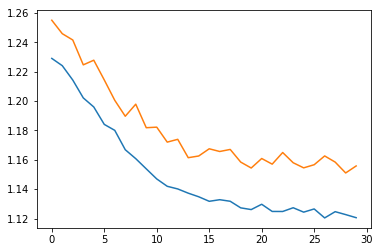

Best training loss = 1.120414
Best validation loss = 1.151020


[1.1510198396707578,
 [2.8773790638602366,
  2.804161282563868,
  2.7156727819176845,
  3.1855191560910385,
  3.1459659466737326,
  3.0133838383277025,
  3.1015799154205768,
  3.1359713618640948,
  3.1398058607174764,
  3.3795892958602822,
  3.163437882500877,
  3.334750620398927,
  2.650348213737053,
  3.1377382228946162,
  3.0202411184887468,
  3.104517902379137,
  2.9519485938204113,
  3.5730289557968646,
  3.6089342791190653,
  2.862025239290241,
  3.09690291149604,
  3.0031203473779073,
  2.738544061029777,
  2.692341700904592,
  4.231891487650865,
  2.99699488195211,
  2.6210259305457337,
  2.8649765207390265,
  3.012492637946966,
  4.2759032300758175,
  3.8051919669231973,
  3.0948675033799398,
  3.2994621406740094,
  2.9986456819755696,
  2.9750302379661306,
  3.7834985941987465,
  3.3947628547319715,
  3.0324470676286066,
  2.774173890200845,
  3.3571628095905277,
  2.964314932524025,
  3.188719516640934,
  3.063457437106596,
  3.525050180858118,
  2.87473459583982,
  2.837848

In [93]:
main_rbm(training=training, validation=validation, trStats=trStats, vlStats=vlStats, 
                             K=5, F=8, epochs=30, gradientLearningRate=0.01,gradientLearningRate_v = 0.001,
                             gradientLearningRate_h = 0.001, minibatch_size=10, alpha=0.9, 
                             stopping=True, momentum=True, learning_rate_type='time', learning_rate_k=0.5, 
                             learning_rate_drop=0.5, learning_rate_epochs_drop=10.0, _lambda = 0.1)

In [103]:
# mrange = np.linspace(0.7,0.95,5)
mrange = [0.9]
# rrange = np.linspace(0.1,0.9,5)
rrange = [0.001, 0.01, 0.1, 0.5, 1]
arange = [0.0001, 0.001, 0.01, 0.1]
brange = [10]
frange = [8]

In [104]:
best_momentum = 0
best_reg = 0
best_epoch = 0
best_B = 0
best_F = 0

### EPOCH 1 ###
Training loss = 1.214263
Validation loss = 1.251047
### EPOCH 2 ###
Training loss = 1.208371
Validation loss = 1.242408
### EPOCH 3 ###
Training loss = 1.204253
Validation loss = 1.239113
### EPOCH 4 ###
Training loss = 1.198777
Validation loss = 1.227314
### EPOCH 5 ###
Training loss = 1.190166
Validation loss = 1.220201
### EPOCH 6 ###
Training loss = 1.179117
Validation loss = 1.218433
### EPOCH 7 ###
Training loss = 1.172086
Validation loss = 1.208395
### EPOCH 8 ###
Training loss = 1.164979
Validation loss = 1.202933
### EPOCH 9 ###
Training loss = 1.157445
Validation loss = 1.186172
### EPOCH 10 ###
Training loss = 1.153025
Validation loss = 1.193356
### EPOCH 11 ###
Training loss = 1.149959
Validation loss = 1.181595
### EPOCH 12 ###
Training loss = 1.143468
Validation loss = 1.171673
### EPOCH 13 ###
Training loss = 1.137900
Validation loss = 1.171918
### EPOCH 14 ###
Training loss = 1.135628
Validation loss = 1.163142
### EPOCH 15 ###
Training loss = 1.133581
V

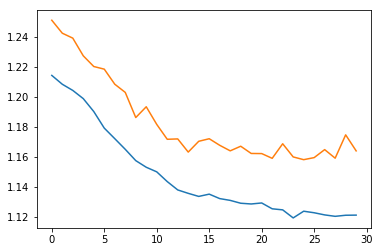

Best training loss = 1.119243
Best validation loss = 1.158079
0.0001
### EPOCH 1 ###
Training loss = 1.220262
Validation loss = 1.242265
### EPOCH 2 ###
Training loss = 1.212828
Validation loss = 1.233451
### EPOCH 3 ###
Training loss = 1.206312
Validation loss = 1.228814
### EPOCH 4 ###
Training loss = 1.197037
Validation loss = 1.226972
### EPOCH 5 ###
Training loss = 1.188753
Validation loss = 1.212944
### EPOCH 6 ###
Training loss = 1.179873
Validation loss = 1.202909
### EPOCH 7 ###
Training loss = 1.171244
Validation loss = 1.202197
### EPOCH 8 ###
Training loss = 1.162710
Validation loss = 1.189403
### EPOCH 9 ###
Training loss = 1.154523
Validation loss = 1.185238
### EPOCH 10 ###
Training loss = 1.149952
Validation loss = 1.180209
### EPOCH 11 ###
Training loss = 1.148857
Validation loss = 1.176412
### EPOCH 12 ###
Training loss = 1.142900
Validation loss = 1.171709
### EPOCH 13 ###
Training loss = 1.138633
Validation loss = 1.165932
### EPOCH 14 ###
Training loss = 1.134702
V

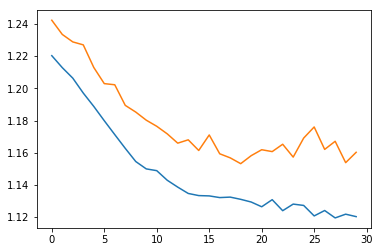

Best training loss = 1.119509
Best validation loss = 1.153199
0.001
### EPOCH 1 ###
Training loss = 1.207506
Validation loss = 1.233317
### EPOCH 2 ###
Training loss = 1.200914
Validation loss = 1.224157
### EPOCH 3 ###
Training loss = 1.198777
Validation loss = 1.228654
### EPOCH 4 ###
Training loss = 1.192699
Validation loss = 1.212603
### EPOCH 5 ###
Training loss = 1.182560
Validation loss = 1.209788
### EPOCH 6 ###
Training loss = 1.175969
Validation loss = 1.204231
### EPOCH 7 ###
Training loss = 1.169855
Validation loss = 1.198269
### EPOCH 8 ###
Training loss = 1.159774
Validation loss = 1.197448
### EPOCH 9 ###
Training loss = 1.154311
Validation loss = 1.177121
### EPOCH 10 ###
Training loss = 1.149054
Validation loss = 1.173895
### EPOCH 11 ###
Training loss = 1.149245
Validation loss = 1.177369
### EPOCH 12 ###
Training loss = 1.141204
Validation loss = 1.167299
### EPOCH 13 ###
Training loss = 1.138839
Validation loss = 1.165737
### EPOCH 14 ###
Training loss = 1.138548
Va

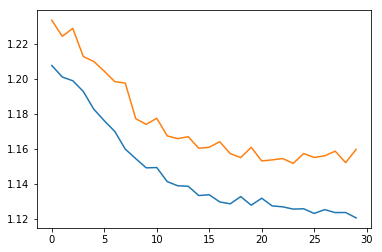

Best training loss = 1.120487
Best validation loss = 1.151627
0.01
### EPOCH 1 ###
Training loss = 1.222727
Validation loss = 1.247555
### EPOCH 2 ###
Training loss = 1.214463
Validation loss = 1.239365
### EPOCH 3 ###
Training loss = 1.203889
Validation loss = 1.233569
### EPOCH 4 ###
Training loss = 1.195818
Validation loss = 1.225805
### EPOCH 5 ###
Training loss = 1.188023
Validation loss = 1.212917
### EPOCH 6 ###
Training loss = 1.178889
Validation loss = 1.214570
### EPOCH 7 ###
Training loss = 1.172660
Validation loss = 1.203000
### EPOCH 8 ###
Training loss = 1.162429
Validation loss = 1.195321
### EPOCH 9 ###
Training loss = 1.151705
Validation loss = 1.193087
### EPOCH 10 ###
Training loss = 1.148557
Validation loss = 1.181233
### EPOCH 11 ###
Training loss = 1.144093
Validation loss = 1.174595
### EPOCH 12 ###
Training loss = 1.138055
Validation loss = 1.175107
### EPOCH 13 ###
Training loss = 1.133263
Validation loss = 1.166329
### EPOCH 14 ###
Training loss = 1.136043
Val

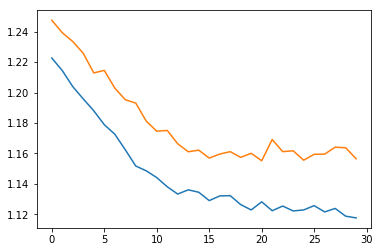

Best training loss = 1.117579
Best validation loss = 1.155177
### EPOCH 1 ###
Training loss = 1.205662
Validation loss = 1.238033
### EPOCH 2 ###
Training loss = 1.201439
Validation loss = 1.233132
### EPOCH 3 ###
Training loss = 1.194307
Validation loss = 1.220522
### EPOCH 4 ###
Training loss = 1.187947
Validation loss = 1.219898
### EPOCH 5 ###
Training loss = 1.181380
Validation loss = 1.205501
### EPOCH 6 ###
Training loss = 1.170803
Validation loss = 1.206606
### EPOCH 7 ###
Training loss = 1.162046
Validation loss = 1.188894
### EPOCH 8 ###
Training loss = 1.156431
Validation loss = 1.195333
### EPOCH 9 ###
Training loss = 1.150802
Validation loss = 1.187880
### EPOCH 10 ###
Training loss = 1.147568
Validation loss = 1.175166
### EPOCH 11 ###
Training loss = 1.142595
Validation loss = 1.180706
### EPOCH 12 ###
Training loss = 1.138628
Validation loss = 1.166240
### EPOCH 13 ###
Training loss = 1.135008
Validation loss = 1.171339
### EPOCH 14 ###
Training loss = 1.136011
Validati

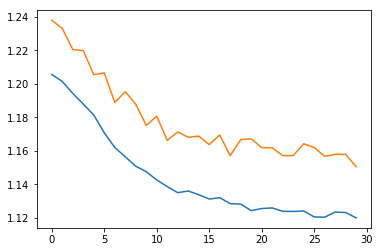

Best training loss = 1.119914
Best validation loss = 1.150483
0.0001
### EPOCH 1 ###
Training loss = 1.214713
Validation loss = 1.248426
### EPOCH 2 ###
Training loss = 1.208054
Validation loss = 1.252489
### EPOCH 3 ###
Training loss = 1.200766
Validation loss = 1.235500
### EPOCH 4 ###
Training loss = 1.194899
Validation loss = 1.231688
### EPOCH 5 ###
Training loss = 1.184838
Validation loss = 1.224744
### EPOCH 6 ###
Training loss = 1.176964
Validation loss = 1.214892
### EPOCH 7 ###
Training loss = 1.172351
Validation loss = 1.206215
### EPOCH 8 ###
Training loss = 1.161916
Validation loss = 1.203021
### EPOCH 9 ###
Training loss = 1.157220
Validation loss = 1.186949
### EPOCH 10 ###
Training loss = 1.150246
Validation loss = 1.189438
### EPOCH 11 ###
Training loss = 1.149521
Validation loss = 1.184650
### EPOCH 12 ###
Training loss = 1.143746
Validation loss = 1.171714
### EPOCH 13 ###
Training loss = 1.141007
Validation loss = 1.181879
### EPOCH 14 ###
Training loss = 1.137167
V

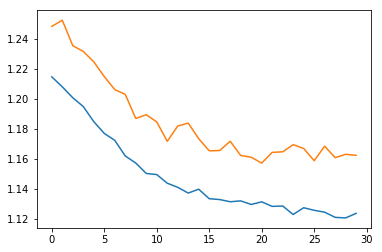

Best training loss = 1.120582
Best validation loss = 1.157160
### EPOCH 1 ###
Training loss = 1.214045
Validation loss = 1.233408
### EPOCH 2 ###
Training loss = 1.211016
Validation loss = 1.228619
### EPOCH 3 ###
Training loss = 1.204741
Validation loss = 1.221255
### EPOCH 4 ###
Training loss = 1.195048
Validation loss = 1.214922
### EPOCH 5 ###
Training loss = 1.182457
Validation loss = 1.205080
### EPOCH 6 ###
Training loss = 1.175181
Validation loss = 1.197917
### EPOCH 7 ###
Training loss = 1.165727
Validation loss = 1.189177
### EPOCH 8 ###
Training loss = 1.160334
Validation loss = 1.184365
### EPOCH 9 ###
Training loss = 1.152711
Validation loss = 1.183000
### EPOCH 10 ###
Training loss = 1.147352
Validation loss = 1.172481
### EPOCH 11 ###
Training loss = 1.147188
Validation loss = 1.172351
### EPOCH 12 ###
Training loss = 1.146912
Validation loss = 1.163670
### EPOCH 13 ###
Training loss = 1.137002
Validation loss = 1.162853
### EPOCH 14 ###
Training loss = 1.133065
Validati

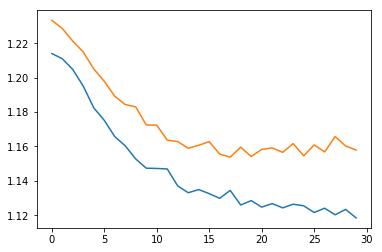

Best training loss = 1.118420
Best validation loss = 1.153762
### EPOCH 1 ###
Training loss = 1.213805
Validation loss = 1.238081
### EPOCH 2 ###
Training loss = 1.206812
Validation loss = 1.246549
### EPOCH 3 ###
Training loss = 1.201754
Validation loss = 1.235413
### EPOCH 4 ###
Training loss = 1.192705
Validation loss = 1.222502
### EPOCH 5 ###
Training loss = 1.181337
Validation loss = 1.214726
### EPOCH 6 ###
Training loss = 1.174035
Validation loss = 1.205506
### EPOCH 7 ###
Training loss = 1.166210
Validation loss = 1.198373
### EPOCH 8 ###
Training loss = 1.160096
Validation loss = 1.198297
### EPOCH 9 ###
Training loss = 1.151768
Validation loss = 1.189872
### EPOCH 10 ###
Training loss = 1.146582
Validation loss = 1.186872
### EPOCH 11 ###
Training loss = 1.143930
Validation loss = 1.171525
### EPOCH 12 ###
Training loss = 1.141358
Validation loss = 1.184583
### EPOCH 13 ###
Training loss = 1.140374
Validation loss = 1.171108
### EPOCH 14 ###
Training loss = 1.133756
Validati

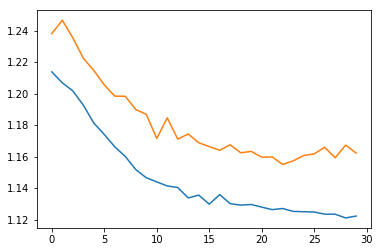

Best training loss = 1.121075
Best validation loss = 1.154995
### EPOCH 1 ###
Training loss = 1.217243
Validation loss = 1.236068
### EPOCH 2 ###
Training loss = 1.211128
Validation loss = 1.233747
### EPOCH 3 ###
Training loss = 1.201645
Validation loss = 1.225203
### EPOCH 4 ###
Training loss = 1.194374
Validation loss = 1.221225
### EPOCH 5 ###
Training loss = 1.186369
Validation loss = 1.216295
### EPOCH 6 ###
Training loss = 1.176833
Validation loss = 1.208142
### EPOCH 7 ###
Training loss = 1.172053
Validation loss = 1.198840
### EPOCH 8 ###
Training loss = 1.161969
Validation loss = 1.191290
### EPOCH 9 ###
Training loss = 1.154188
Validation loss = 1.183269
### EPOCH 10 ###
Training loss = 1.150349
Validation loss = 1.177213
### EPOCH 11 ###
Training loss = 1.144055
Validation loss = 1.178983
### EPOCH 12 ###
Training loss = 1.144132
Validation loss = 1.176033
### EPOCH 13 ###
Training loss = 1.140967
Validation loss = 1.176816
### EPOCH 14 ###
Training loss = 1.137346
Validati

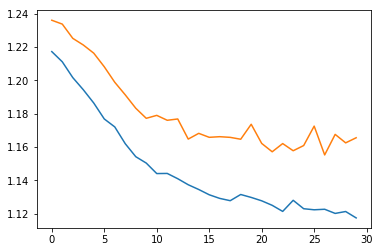

Best training loss = 1.117440
Best validation loss = 1.155245
### EPOCH 1 ###
Training loss = 1.212918
Validation loss = 1.237281
### EPOCH 2 ###
Training loss = 1.209294
Validation loss = 1.229376
### EPOCH 3 ###
Training loss = 1.202219
Validation loss = 1.227274
### EPOCH 4 ###
Training loss = 1.195483
Validation loss = 1.214760
### EPOCH 5 ###
Training loss = 1.188274
Validation loss = 1.210871
### EPOCH 6 ###
Training loss = 1.179068
Validation loss = 1.207404
### EPOCH 7 ###
Training loss = 1.172470
Validation loss = 1.192797
### EPOCH 8 ###
Training loss = 1.158348
Validation loss = 1.181184
### EPOCH 9 ###
Training loss = 1.153260
Validation loss = 1.174543
### EPOCH 10 ###
Training loss = 1.148990
Validation loss = 1.175186
### EPOCH 11 ###
Training loss = 1.146108
Validation loss = 1.174184
### EPOCH 12 ###
Training loss = 1.140852
Validation loss = 1.171574
### EPOCH 13 ###
Training loss = 1.138630
Validation loss = 1.157462
### EPOCH 14 ###
Training loss = 1.134025
Validati

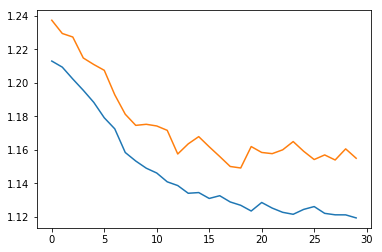

Best training loss = 1.119314
Best validation loss = 1.149108
0.001
### EPOCH 1 ###
Training loss = 1.220253
Validation loss = 1.235936
### EPOCH 2 ###
Training loss = 1.215394
Validation loss = 1.235249
### EPOCH 3 ###
Training loss = 1.203774
Validation loss = 1.220382
### EPOCH 4 ###
Training loss = 1.199157
Validation loss = 1.222807
### EPOCH 5 ###
Training loss = 1.192742
Validation loss = 1.207364
### EPOCH 6 ###
Training loss = 1.179564
Validation loss = 1.199036
### EPOCH 7 ###
Training loss = 1.172964
Validation loss = 1.202991
### EPOCH 8 ###
Training loss = 1.167050
Validation loss = 1.182727
### EPOCH 9 ###
Training loss = 1.159762
Validation loss = 1.185694
### EPOCH 10 ###
Training loss = 1.152232
Validation loss = 1.182849
### EPOCH 11 ###
Training loss = 1.147484
Validation loss = 1.167531
### EPOCH 12 ###
Training loss = 1.145794
Validation loss = 1.176786
### EPOCH 13 ###
Training loss = 1.143222
Validation loss = 1.173068
### EPOCH 14 ###
Training loss = 1.141998
Va

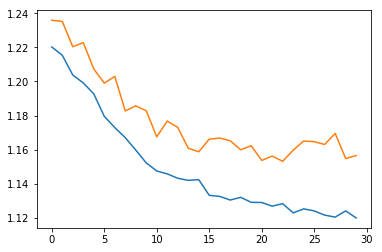

Best training loss = 1.119949
Best validation loss = 1.153158
### EPOCH 1 ###
Training loss = 1.213670
Validation loss = 1.244709
### EPOCH 2 ###
Training loss = 1.206869
Validation loss = 1.233511
### EPOCH 3 ###
Training loss = 1.204312
Validation loss = 1.232883
### EPOCH 4 ###
Training loss = 1.195566
Validation loss = 1.221016
### EPOCH 5 ###
Training loss = 1.187085
Validation loss = 1.217604
### EPOCH 6 ###
Training loss = 1.177132
Validation loss = 1.206194
### EPOCH 7 ###
Training loss = 1.171131
Validation loss = 1.205488
### EPOCH 8 ###
Training loss = 1.167711
Validation loss = 1.191743
### EPOCH 9 ###
Training loss = 1.155349
Validation loss = 1.185367
### EPOCH 10 ###
Training loss = 1.152416
Validation loss = 1.181611
### EPOCH 11 ###
Training loss = 1.146461
Validation loss = 1.183143
### EPOCH 12 ###
Training loss = 1.143330
Validation loss = 1.167166
### EPOCH 13 ###
Training loss = 1.141892
Validation loss = 1.170106
### EPOCH 14 ###
Training loss = 1.139511
Validati

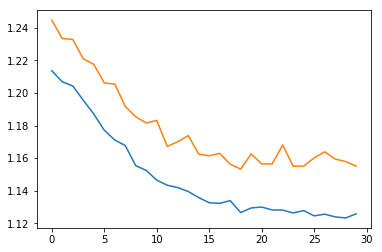

Best training loss = 1.123255
Best validation loss = 1.153261
### EPOCH 1 ###
Training loss = 1.219387
Validation loss = 1.241442
### EPOCH 2 ###
Training loss = 1.210803
Validation loss = 1.231779
### EPOCH 3 ###
Training loss = 1.201685
Validation loss = 1.234562
### EPOCH 4 ###
Training loss = 1.195454
Validation loss = 1.219869
### EPOCH 5 ###
Training loss = 1.187678
Validation loss = 1.212080
### EPOCH 6 ###
Training loss = 1.179668
Validation loss = 1.205311
### EPOCH 7 ###
Training loss = 1.171043
Validation loss = 1.201714
### EPOCH 8 ###
Training loss = 1.163550
Validation loss = 1.191531
### EPOCH 9 ###
Training loss = 1.161047
Validation loss = 1.188630
### EPOCH 10 ###
Training loss = 1.153421
Validation loss = 1.184912
### EPOCH 11 ###
Training loss = 1.147605
Validation loss = 1.178672
### EPOCH 12 ###
Training loss = 1.144067
Validation loss = 1.176971
### EPOCH 13 ###
Training loss = 1.141008
Validation loss = 1.177600
### EPOCH 14 ###
Training loss = 1.138172
Validati

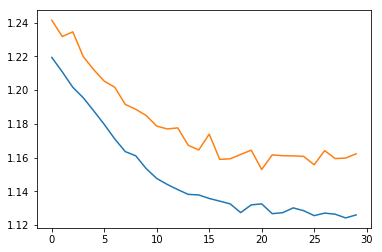

Best training loss = 1.124215
Best validation loss = 1.152946
### EPOCH 1 ###
Training loss = 1.215818
Validation loss = 1.245968
### EPOCH 2 ###
Training loss = 1.208038
Validation loss = 1.241089
### EPOCH 3 ###
Training loss = 1.201116
Validation loss = 1.232293
### EPOCH 4 ###
Training loss = 1.194731
Validation loss = 1.217873
### EPOCH 5 ###
Training loss = 1.186734
Validation loss = 1.215742
### EPOCH 6 ###
Training loss = 1.179882
Validation loss = 1.209483
### EPOCH 7 ###
Training loss = 1.171404
Validation loss = 1.202447
### EPOCH 8 ###
Training loss = 1.164564
Validation loss = 1.199635
### EPOCH 9 ###
Training loss = 1.161142
Validation loss = 1.191428
### EPOCH 10 ###
Training loss = 1.156610
Validation loss = 1.186771
### EPOCH 11 ###
Training loss = 1.148771
Validation loss = 1.179994
### EPOCH 12 ###
Training loss = 1.145759
Validation loss = 1.170459
### EPOCH 13 ###
Training loss = 1.143183
Validation loss = 1.173662
### EPOCH 14 ###
Training loss = 1.139740
Validati

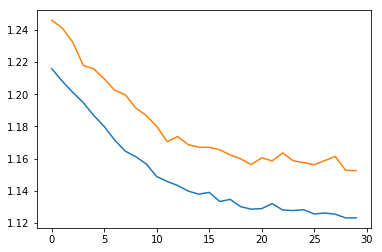

Best training loss = 1.123076
Best validation loss = 1.152477
### EPOCH 1 ###
Training loss = 1.213016
Validation loss = 1.244146
### EPOCH 2 ###
Training loss = 1.210868
Validation loss = 1.237078
### EPOCH 3 ###
Training loss = 1.202297
Validation loss = 1.236646
### EPOCH 4 ###
Training loss = 1.194322
Validation loss = 1.225354
### EPOCH 5 ###
Training loss = 1.186784
Validation loss = 1.212112
### EPOCH 6 ###
Training loss = 1.178871
Validation loss = 1.211787
### EPOCH 7 ###
Training loss = 1.173747
Validation loss = 1.202850
### EPOCH 8 ###
Training loss = 1.164051
Validation loss = 1.193462
### EPOCH 9 ###
Training loss = 1.160764
Validation loss = 1.191848
### EPOCH 10 ###
Training loss = 1.155508
Validation loss = 1.184853
### EPOCH 11 ###
Training loss = 1.150735
Validation loss = 1.177546
### EPOCH 12 ###
Training loss = 1.144694
Validation loss = 1.177206
### EPOCH 13 ###
Training loss = 1.145037
Validation loss = 1.168068
### EPOCH 14 ###
Training loss = 1.138882
Validati

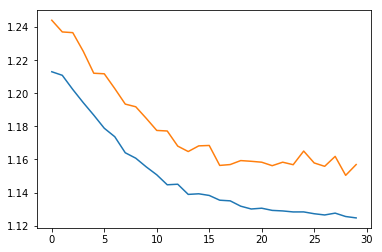

Best training loss = 1.124669
Best validation loss = 1.150404
### EPOCH 1 ###
Training loss = 1.211998
Validation loss = 1.233290
### EPOCH 2 ###
Training loss = 1.211205
Validation loss = 1.228106
### EPOCH 3 ###
Training loss = 1.202402
Validation loss = 1.219101
### EPOCH 4 ###
Training loss = 1.194609
Validation loss = 1.217087
### EPOCH 5 ###
Training loss = 1.189172
Validation loss = 1.209191
### EPOCH 6 ###
Training loss = 1.182148
Validation loss = 1.205026
### EPOCH 7 ###
Training loss = 1.172846
Validation loss = 1.200414
### EPOCH 8 ###
Training loss = 1.167812
Validation loss = 1.190693
### EPOCH 9 ###
Training loss = 1.159340
Validation loss = 1.187680
### EPOCH 10 ###
Training loss = 1.156235
Validation loss = 1.184028
### EPOCH 11 ###
Training loss = 1.153439
Validation loss = 1.176727
### EPOCH 12 ###
Training loss = 1.150719
Validation loss = 1.172342
### EPOCH 13 ###
Training loss = 1.142623
Validation loss = 1.172016
### EPOCH 14 ###
Training loss = 1.140180
Validati

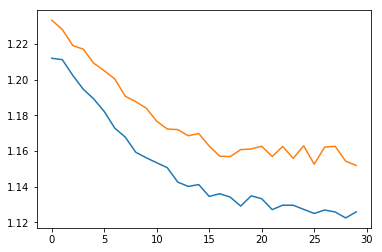

Best training loss = 1.122542
Best validation loss = 1.151943
### EPOCH 1 ###
Training loss = 1.217236
Validation loss = 1.236736
### EPOCH 2 ###
Training loss = 1.211916
Validation loss = 1.235373
### EPOCH 3 ###
Training loss = 1.205207
Validation loss = 1.228206
### EPOCH 4 ###
Training loss = 1.197522
Validation loss = 1.223336
### EPOCH 5 ###
Training loss = 1.191503
Validation loss = 1.213004
### EPOCH 6 ###
Training loss = 1.183301
Validation loss = 1.207433
### EPOCH 7 ###
Training loss = 1.177143
Validation loss = 1.204675
### EPOCH 8 ###
Training loss = 1.171491
Validation loss = 1.194263
### EPOCH 9 ###
Training loss = 1.164498
Validation loss = 1.191379
### EPOCH 10 ###
Training loss = 1.159881
Validation loss = 1.187714
### EPOCH 11 ###
Training loss = 1.155348
Validation loss = 1.179151
### EPOCH 12 ###
Training loss = 1.151473
Validation loss = 1.178539
### EPOCH 13 ###
Training loss = 1.148222
Validation loss = 1.172742
### EPOCH 14 ###
Training loss = 1.145353
Validati

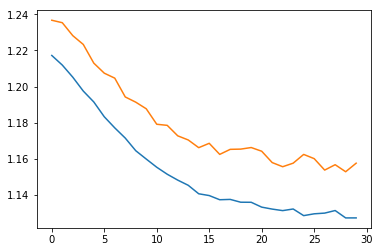

Best training loss = 1.127293
Best validation loss = 1.152859
### EPOCH 1 ###
Training loss = 1.203795
Validation loss = 1.235352
### EPOCH 2 ###
Training loss = 1.198672
Validation loss = 1.230154
### EPOCH 3 ###
Training loss = 1.196391
Validation loss = 1.224545
### EPOCH 4 ###
Training loss = 1.191078
Validation loss = 1.216976
### EPOCH 5 ###
Training loss = 1.186552
Validation loss = 1.211263
### EPOCH 6 ###
Training loss = 1.179562
Validation loss = 1.209340
### EPOCH 7 ###
Training loss = 1.173060
Validation loss = 1.204007
### EPOCH 8 ###
Training loss = 1.168994
Validation loss = 1.196104
### EPOCH 9 ###
Training loss = 1.162220
Validation loss = 1.188672
### EPOCH 10 ###
Training loss = 1.159891
Validation loss = 1.185214
### EPOCH 11 ###
Training loss = 1.154206
Validation loss = 1.183770
### EPOCH 12 ###
Training loss = 1.150673
Validation loss = 1.174615
### EPOCH 13 ###
Training loss = 1.148330
Validation loss = 1.175408
### EPOCH 14 ###
Training loss = 1.146866
Validati

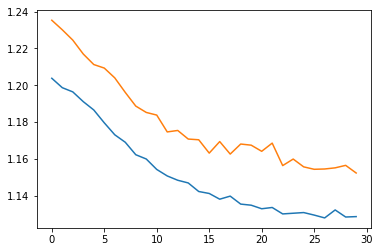

Best training loss = 1.127846
Best validation loss = 1.152275
### EPOCH 1 ###
Training loss = 1.226014
Validation loss = 1.254791
### EPOCH 2 ###
Training loss = 1.217479
Validation loss = 1.246756
### EPOCH 3 ###
Training loss = 1.209650
Validation loss = 1.231070
### EPOCH 4 ###
Training loss = 1.201503
Validation loss = 1.223749
### EPOCH 5 ###
Training loss = 1.192901
Validation loss = 1.216646
### EPOCH 6 ###
Training loss = 1.183818
Validation loss = 1.210633
### EPOCH 7 ###
Training loss = 1.179529
Validation loss = 1.206546
### EPOCH 8 ###
Training loss = 1.170658
Validation loss = 1.198725
### EPOCH 9 ###
Training loss = 1.163380
Validation loss = 1.188352
### EPOCH 10 ###
Training loss = 1.161763
Validation loss = 1.188171
### EPOCH 11 ###
Training loss = 1.155426
Validation loss = 1.182200
### EPOCH 12 ###
Training loss = 1.150829
Validation loss = 1.179429
### EPOCH 13 ###
Training loss = 1.146849
Validation loss = 1.174373
### EPOCH 14 ###
Training loss = 1.146709
Validati

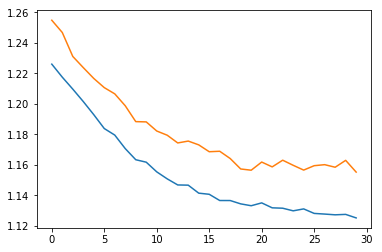

Best training loss = 1.125243
Best validation loss = 1.155272
### EPOCH 1 ###
Training loss = 1.214791
Validation loss = 1.234209
### EPOCH 2 ###
Training loss = 1.209089
Validation loss = 1.232442
### EPOCH 3 ###
Training loss = 1.202213
Validation loss = 1.226769
### EPOCH 4 ###
Training loss = 1.194515
Validation loss = 1.218152
### EPOCH 5 ###
Training loss = 1.187676
Validation loss = 1.213238
### EPOCH 6 ###
Training loss = 1.180880
Validation loss = 1.207595
### EPOCH 7 ###
Training loss = 1.175111
Validation loss = 1.200551
### EPOCH 8 ###
Training loss = 1.168943
Validation loss = 1.196549
### EPOCH 9 ###
Training loss = 1.163400
Validation loss = 1.185857
### EPOCH 10 ###
Training loss = 1.158837
Validation loss = 1.187726
### EPOCH 11 ###
Training loss = 1.156064
Validation loss = 1.183340
### EPOCH 12 ###
Training loss = 1.152588
Validation loss = 1.178350
### EPOCH 13 ###
Training loss = 1.147659
Validation loss = 1.175624
### EPOCH 14 ###
Training loss = 1.145390
Validati

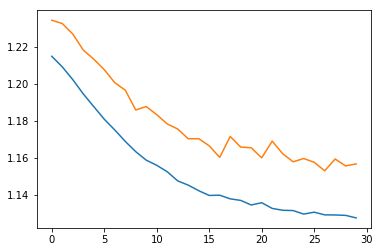

Best training loss = 1.127718
Best validation loss = 1.153092


In [105]:
min_rmse=10
for momentum in mrange:
    for regularization in rrange:
        for learning_rate in arange:
            for batch in brange:
                for F in frange:
                    prediction = main_rbm(training=training, validation=validation, trStats=trStats, vlStats=vlStats, 
                                 K=5, F=int(F), epochs=30, gradientLearningRate=learning_rate, gradientLearningRate_v = 0.001,
                                 gradientLearningRate_h = 0.001, minibatch_size=int(batch), alpha=momentum, 
                                 stopping=True, momentum=True, learning_rate_type='time', learning_rate_k=0.5, 
                                 learning_rate_drop=0.5, learning_rate_epochs_drop=10.0, _lambda = regularization)
                    if prediction[0] < min_rmse:
                        best_momentum = momentum
                        best_reg = regularization
#                             best_epoch = epoch
                        best_alpha = learning_rate
                        print(best_alpha)
                        best_B = batch
                        best_F = F
                        best_predict = prediction[1]
                        min_rmse = prediction[0]

In [108]:
best_momentum
best_reg
best_alpha #this is the learning rate
best_B
best_F
min_rmse

0.9

0.1

0.001

10

8

1.1491075824863284

In [112]:
best_predict
np.savetxt("SpateggiChikenChoope+v1.txt", best_predict)

4.362470160965783

In [18]:
main_rbm()

Training and Predicting with the following hyperparameters:
    K = 5
    F = 5
    epochs = 30
    gradientLearningRate = 0.0001
    gradientLearningRate_v = 0.001
    gradientLearningRate_h = 0.001
    minibatch_size = 10
    alpha = 0.9
    stopping = False
    momentum = False
    learning_rate_type = time
    learning_rate_k = 0.1
    learning_rate_drop = 0.5
    learning_rate_epochs_drop = 10.0
    _lambda = 0.3
### EPOCH 1 ###
Training loss = 1.211313
Validation loss = 1.234726
### EPOCH 2 ###
Training loss = 1.210378
Validation loss = 1.233583
### EPOCH 3 ###
Training loss = 1.210287
Validation loss = 1.233736
### EPOCH 4 ###
Training loss = 1.210319
Validation loss = 1.233667
### EPOCH 5 ###
Training loss = 1.209675
Validation loss = 1.232671
### EPOCH 6 ###
Training loss = 1.209158
Validation loss = 1.232595


KeyboardInterrupt: 

In [ ]:
main_rbm(momentum=True)

In [ ]:
main_rbm(stopping=True)

In [ ]:
main_rbm(learning_rate_type='time', learning_rate_k=0.1)

In [ ]:
main_rbm(learning_rate_type='step', learning_rate_drop=0.5, learning_rate_epochs_drop=10.0)

In [ ]:
main_rbm(learning_rate_type='exponential', learning_rate_k=0.5)

Training and Predicting with the following hyperparameters:
    K = 5
    F = 8
    epochs = 30
    gradientLearningRate = 0.0001
    gradientLearningRate_v = 0.001
    gradientLearningRate_h = 0.001
    minibatch_size = 10
    alpha = 0.9
    stopping = True
    momentum = True
    learning_rate_type = time
    learning_rate_k = 0.5
    learning_rate_drop = 0.5
    learning_rate_epochs_drop = 10.0
    _lambda = 0.3
### EPOCH 1 ###
Training loss = 1.209519
Validation loss = 1.233369
### EPOCH 2 ###
Training loss = 1.209034
Validation loss = 1.232448
### EPOCH 3 ###
Training loss = 1.210040
Validation loss = 1.233395
### EPOCH 4 ###
Training loss = 1.209857
Validation loss = 1.233978
### EPOCH 5 ###
Training loss = 1.209707
Validation loss = 1.234003
### EPOCH 6 ###
Training loss = 1.209413
Validation loss = 1.232723
### EPOCH 7 ###
Training loss = 1.209471
Validation loss = 1.232981
### EPOCH 8 ###
Training loss = 1.209625
Validation loss = 1.233306
### EPOCH 9 ###
Training loss = 1.21

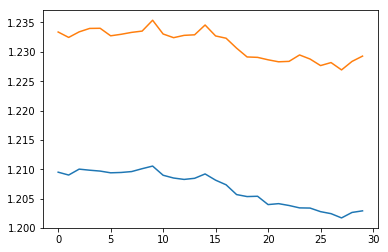

Best training loss = 1.201739
Best validation loss = 1.226921


In [19]:
main_rbm(F=8, learning_rate_type='time', learning_rate_k=0.5, stopping=True, momentum=True)

In [71]:
best_train_loss
best_validation_loss
min(best_train_predictions)
max(best_train_predictions)
min(best_validation_predictions)
max(best_validation_predictions)

NameError: name 'best_train_loss' is not defined